# Rapprochement entre l'ERP et le CMS

# [1. Nettoyage et fusion des données](#H1)

   [1.1 Chargement des données et premier traitement sur les valeurs manquantes](#H11)  
   [1.2 Identification et traitement des clés primaires](#H12)  
   [1.3 Jointure entre le CMS et ERP](#H13)  
   [1.4 Analyse univariée sur une variable qualitative](#H14)  
   [1.5 Analyse univariée sur une variable quantitative](#H15)  

# [2. Analyse du CA généré par les ventes](#H2)
   [2.1 CA calculé en fonction du nombre de ventes par produits](#H21)  
   [2.2 CA généré par les ventes en ligne](#H22)  

# [3. Analyse des outliers](#H3)
   [3.1 Représentation graphique des outliers avec boxplot](#H31)  
   [3.2 IQR pour calculer les limites d'une distribution](#H32)  
   [3.3 La méthode du Z score](#H33)

# 1. Nettoyage et fusion des données <a name="H1"></a>

## 1.1 Chargement des données et premier traitement sur les valeurs manquantes <a name="H11"></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [47]:
# import du CMS et de l'ERP
web_df = pd.read_excel('../data/WEB.xlsx', header=0)
erp_df = pd.read_excel('../data/ERP.xlsx', header=0)
product_sku_link = pd.read_excel('../data/liaison.xlsx', header=0)

In [48]:
# Fonction qui traite les lignes et les colonnes entièrement nulles

def treatment_na_values(df : pd.DataFrame) :
    
    
    initial_nb_row, initial_nb_columns = df.shape
    df.drop_duplicates(inplace=True)
    
    # on supprime les colonnes entièrement nulles 
    for column_name in (df == 0).all().index:
        if (df == 0).all().loc[column_name]:
            df.drop(columns=column_name)
        
    df.dropna(how='all', axis = 1, inplace = True)
    df.dropna(how='all', axis = 0, inplace = True) 
    print("{0} rows have been deleted".format(initial_nb_row - df.shape[0]))
    print("{} columns have been deleted".format(initial_nb_columns - df.shape[1]))
    

In [49]:
# On supprime les colonnes et les lignes entièrement nulles sur nos 3 datasets
treatment_na_values(web_df)
treatment_na_values(erp_df)
treatment_na_values(product_sku_link)

82 rows have been deleted
4 columns have been deleted
0 rows have been deleted
0 columns have been deleted
0 rows have been deleted
0 columns have been deleted


In [50]:
# Etude sur les valeurs manquantes
product_sku_link.isnull().sum()

product_id     0
id_web        91
dtype: int64

In [51]:
product_sku_link.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 19.3+ KB


In [52]:
# check des valeurs nulles indépendantes
erp_df.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

In [53]:
# Detecter les variables multivaluées (type object)
erp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 38.7+ KB


## 1.2 Identification et traitement des clés primaires <a name="H12"></a>

In [54]:
# Fonction qui teste la condition d'authenticité sur chacune des variables d'un dataframe
def is_primary_key(df : pd.DataFrame, columns):
    
    length = len(df.dropna(subset=[columns]))
    is_primary_key = False
    
    if length == len(df.dropna(subset=[columns]).drop_duplicates(subset=[columns])) :
        print("{} can be a PK ! ".format(columns))
        is_primary_key = True
    else :
        print("{} is not a PK !".format(columns))
    return is_primary_key

In [55]:
# Fonction qui détecte et renvoie les valeurs multivaluées

def dtype_object(df) : 
    
    objects_dtype_var = []
    for var in df.columns:
        if (df[var].dtype == 'object') & (is_primary_key(df, var) == False):
            objects_dtype_var.append(var)
            
    print("object dtypes features : {}".format(objects_dtype_var))
    return objects_dtype_var

In [56]:
is_primary_key(erp_df, 'product_id')

product_id can be a PK ! 


True

In [57]:
dtype_object(erp_df)

product_id can be a PK ! 
onsale_web is not a PK !
price is not a PK !
stock_quantity is not a PK !
stock_status is not a PK !
object dtypes features : ['stock_status']


['stock_status']

In [58]:
dtype_object(web_df)

sku is not a PK !
virtual is not a PK !
downloadable is not a PK !
rating_count is not a PK !
average_rating is not a PK !
total_sales is not a PK !
tax_status is not a PK !
post_author is not a PK !
post_date is not a PK !
post_date_gmt is not a PK !
post_title is not a PK !
post_excerpt is not a PK !
post_status is not a PK !
comment_status is not a PK !
ping_status is not a PK !
post_name is not a PK !
post_modified is not a PK !
post_modified_gmt is not a PK !
post_parent is not a PK !
guid can be a PK ! 
menu_order is not a PK !
post_type is not a PK !
post_mime_type is not a PK !
comment_count is not a PK !
object dtypes features : ['sku', 'tax_status', 'post_title', 'post_excerpt', 'post_status', 'comment_status', 'ping_status', 'post_name', 'post_type', 'post_mime_type']


['sku',
 'tax_status',
 'post_title',
 'post_excerpt',
 'post_status',
 'comment_status',
 'ping_status',
 'post_name',
 'post_type',
 'post_mime_type']

In [59]:
# Analyse sur les sku == Nan et regarder les valeurs des autres colonnes
web_df[web_df['sku'].isna() == True]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
178,NaN,0,0,0,NaN,NaN,NaN,NaN,NaT,NaT,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
470,NaN,0,0,0,0.0,0.0,taxable,2.0,2018-07-31 12:07:23,2018-07-31 10:07:23,...,closed,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,2.0,2018-08-08 11:23:43,2018-08-08 09:23:43,...,closed,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [60]:
# Suite à la décision prise avec les équipes produit 
# Supprime les lignes dont on ne connait pas la référence du produit dans la boutique en ligne
web_df.dropna(how = 'all', subset=['sku'], inplace=True)

In [61]:
# Test sur toutes les variables d'un dataset la condition de la PK
dtype_object(web_df)

sku is not a PK !
virtual is not a PK !
downloadable is not a PK !
rating_count is not a PK !
average_rating is not a PK !
total_sales is not a PK !
tax_status is not a PK !
post_author is not a PK !
post_date is not a PK !
post_date_gmt is not a PK !
post_title is not a PK !
post_excerpt is not a PK !
post_status is not a PK !
comment_status is not a PK !
ping_status is not a PK !
post_name is not a PK !
post_modified is not a PK !
post_modified_gmt is not a PK !
post_parent is not a PK !
guid can be a PK ! 
menu_order is not a PK !
post_type is not a PK !
post_mime_type is not a PK !
comment_count is not a PK !
object dtypes features : ['sku', 'tax_status', 'post_title', 'post_excerpt', 'post_status', 'comment_status', 'ping_status', 'post_name', 'post_type', 'post_mime_type']


['sku',
 'tax_status',
 'post_title',
 'post_excerpt',
 'post_status',
 'comment_status',
 'ping_status',
 'post_name',
 'post_type',
 'post_mime_type']

In [62]:
# Affiche les doublons pour la variable sku
web_df.loc[web_df.duplicated(subset=['sku']),:]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
799,15298,0,0,0,0.0,6.0,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,...,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
800,15296,0,0,0,0.0,0.0,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,...,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
801,15300,0,0,0,0.0,0.0,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,...,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
802,19814,0,0,0,0.0,3.0,NaN,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,...,closed,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
803,19815,0,0,0,0.0,0.0,NaN,2.0,2018-02-12 09:04:37,2018-02-12 08:04:37,...,closed,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,0,0,0,0.0,5.0,NaN,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,...,closed,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15891,0,0,0,0.0,0.0,NaN,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,...,closed,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1510,15887,0,0,0,0.0,0.0,NaN,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,...,closed,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1511,13127-1,0,0,0,0.0,0.0,NaN,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,...,closed,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [63]:
# analyse pour confirmer la suppression des doublons (Attachment vs product)
web_df[web_df['sku'] == 16135]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
762,16135,0,0,0,0.0,5.0,taxable,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,...,closed,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1508,16135,0,0,0,0.0,5.0,NaN,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,...,closed,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [64]:
#Supprime les doublons dans la colonne sku (clé primaire de notre dataset CMS)
web_df.drop_duplicates(subset=['sku'], inplace = True)

In [65]:
dtype_object(web_df)

sku can be a PK ! 
virtual is not a PK !
downloadable is not a PK !
rating_count is not a PK !
average_rating is not a PK !
total_sales is not a PK !
tax_status is not a PK !
post_author is not a PK !
post_date can be a PK ! 
post_date_gmt can be a PK ! 
post_title is not a PK !
post_excerpt is not a PK !
post_status is not a PK !
comment_status is not a PK !
ping_status is not a PK !
post_name can be a PK ! 
post_modified is not a PK !
post_modified_gmt is not a PK !
post_parent is not a PK !
guid can be a PK ! 
menu_order is not a PK !
post_type is not a PK !
post_mime_type can be a PK ! 
comment_count is not a PK !
object dtypes features : ['tax_status', 'post_title', 'post_excerpt', 'post_status', 'comment_status', 'ping_status', 'post_type']


['tax_status',
 'post_title',
 'post_excerpt',
 'post_status',
 'comment_status',
 'ping_status',
 'post_type']

In [66]:
# On filtre uniquement sur les sku qui commencent par un chiffre
web_df.set_index('sku').filter(regex="^[0-9]", axis=0)

,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
sku,,,,,,,,,,,,,,,,,,,,,
15298,0,0,0,0.0,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,...,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
15296,0,0,0,0.0,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,...,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
15300,0,0,0,0.0,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,...,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
19814,0,0,0,0.0,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,...,closed,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
19815,0,0,0,0.0,0.0,taxable,2.0,2018-02-12 09:04:37,2018-02-12 08:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017,...,closed,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16135,0,0,0,0.0,5.0,taxable,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,...,closed,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
15891,0,0,0,0.0,0.0,taxable,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,...,closed,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
15887,0,0,0,0.0,0.0,taxable,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,...,closed,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [67]:
# Garder en mémoire l'irrégularité de la variable sku au cas ou des modifications doivent être faites
sku_errone = web_df.set_index('sku').filter(regex="^[a-z]", axis=0)

In [68]:
sku_errone

,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
sku,,,,,,,,,,,,,,,,,,,,,
bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,...,closed,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [69]:
# Verifier qu'après tous les traitements, notre variable sku respecte les conditions d'unicité
dtype_object(web_df)

sku can be a PK ! 
virtual is not a PK !
downloadable is not a PK !
rating_count is not a PK !
average_rating is not a PK !
total_sales is not a PK !
tax_status is not a PK !
post_author is not a PK !
post_date can be a PK ! 
post_date_gmt can be a PK ! 
post_title is not a PK !
post_excerpt is not a PK !
post_status is not a PK !
comment_status is not a PK !
ping_status is not a PK !
post_name can be a PK ! 
post_modified is not a PK !
post_modified_gmt is not a PK !
post_parent is not a PK !
guid can be a PK ! 
menu_order is not a PK !
post_type is not a PK !
post_mime_type can be a PK ! 
comment_count is not a PK !
object dtypes features : ['tax_status', 'post_title', 'post_excerpt', 'post_status', 'comment_status', 'ping_status', 'post_type']


['tax_status',
 'post_title',
 'post_excerpt',
 'post_status',
 'comment_status',
 'ping_status',
 'post_type']

## 1.3 Jointure entre CMS et ERP <a name="H13"></a>

In [70]:
erp_df.set_index('product_id', inplace=True)

In [71]:
product_sku_link_merged = pd.merge(product_sku_link, erp_df,on='product_id', how= 'outer', indicator = True)

In [72]:
# Les produits sont les mêmes dans l'ERP et le fichier de Sylvie
product_sku_link_merged.loc[product_sku_link_merged["_merge"] == 'both','_merge'].value_counts()

both          825
left_only       0
right_only      0
Name: _merge, dtype: int64

In [73]:
product_sku_link_merged.drop(columns="_merge", inplace=True)
web_df.rename(columns={'sku' : 'id_web'}, inplace=True)
web_df.set_index('id_web', inplace=True)

In [74]:
erp_cms_df = pd.merge(product_sku_link_merged, web_df, on='id_web', how='outer', indicator = True)

In [75]:
erp_cms_df['_merge'].value_counts()

both          714
left_only     111
right_only      0
Name: _merge, dtype: int64

In [76]:
# doit-on garder les produits sur l'ERP qui ne sont pas dans le CMS ?
# Hypothèse : Un produit peut être commercialisé en magasin et ne pas l'être sur la boutique en ligne
erp_cms_df[erp_cms_df['_merge'] != 'both'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 19 to 823
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_id         111 non-null    int64         
 1   id_web             20 non-null     object        
 2   onsale_web         111 non-null    int64         
 3   price              111 non-null    float64       
 4   stock_quantity     111 non-null    int64         
 5   stock_status       111 non-null    object        
 6   virtual            0 non-null      float64       
 7   downloadable       0 non-null      float64       
 8   rating_count       0 non-null      float64       
 9   average_rating     0 non-null      float64       
 10  total_sales        0 non-null      float64       
 11  tax_status         0 non-null      object        
 12  post_author        0 non-null      float64       
 13  post_date          0 non-null      datetime64[ns]
 14  post_date

In [73]:
# La jointure a supprimé d'elle même la valeur irrégulière de notre variable sku
erp_cms_df[(erp_cms_df['_merge'] != 'both') & (~erp_cms_df['id_web'].isna())][['id_web','product_id','_merge']]

,id_web,product_id,_merge
276,13771,4289,left_only
318,15065,4568,left_only
321,14785,4584,left_only
425,12601,4741,left_only
459,15154,4864,left_only
462,14360,4869,left_only
490,15608,4921,left_only
491,15586,4922,left_only
534,15272,5018,left_only
536,15630,5021,left_only


In [74]:
# On supprime les colonnes et les lignes entièrement nulles
treatment_na_values(erp_cms_df)

0 rows have been deleted from
1 columns have been deleted


In [75]:
erp_cms_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   product_id         825 non-null    int64         
 1   id_web             734 non-null    object        
 2   onsale_web         825 non-null    int64         
 3   price              825 non-null    float64       
 4   stock_quantity     825 non-null    int64         
 5   stock_status       825 non-null    object        
 6   virtual            714 non-null    float64       
 7   downloadable       714 non-null    float64       
 8   rating_count       714 non-null    float64       
 9   average_rating     714 non-null    float64       
 10  total_sales        714 non-null    float64       
 11  tax_status         714 non-null    object        
 12  post_author        714 non-null    float64       
 13  post_date          714 non-null    datetime64[ns]
 14  post_date_

In [76]:
# Analyser les produits qui sont enregistré dans l'ERP uniquement
erp_cms_df.loc[erp_cms_df['id_web'].isna(), :]

,product_id,id_web,onsale_web,price,stock_quantity,stock_status,virtual,downloadable,rating_count,average_rating,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge
19,4055,NaN,0,86.1,0,outofstock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
20,4090,NaN,0,73.0,0,outofstock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
21,4092,NaN,0,47.0,0,outofstock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
22,4195,NaN,0,14.1,0,outofstock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
23,4209,NaN,0,73.5,0,outofstock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,7196,NaN,0,31.0,55,instock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
106,7200,NaN,0,31.0,6,instock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
107,7201,NaN,0,31.0,18,instock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
108,7203,NaN,0,45.0,30,instock,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only


In [77]:
# Affiche la distribution d'une variable quantitative et les fréquences d'une variable qualitative
from matplotlib import pyplot as plt

def oneD_analysis(df, var_list = 'all', quant = False, columns = 2):
    
    
    if len(var_list) % 2 == 0 :
        row = int(len(var_list) / 2)
    else :
        row = int(len(var_list) / 2) + 1
    
    if var_list == 'all':
        var_list = df.columns
    ax_i=0
    ax_j=0
             
    if quant :
        row = len(var_list)
        fig, axes = plt.subplots(row, figsize=(8,6))
        for var in var_list :  
            sns.boxplot(x = df[var], ax = axes[ax_i])
            ax_i+=1
            
    else :
        fig, axes = plt.subplots(row, columns, figsize=(8,6)) 
        for var in var_list : 
            print(12)     
            if (ax_i % 2 == 0) & (ax_i != 0) :
                ax_i = 0
                ax_j+=1

            data = pd.DataFrame(df[var].value_counts())
            missing_value = df.shape[0] - data[var].sum()
            data = data.append(pd.DataFrame({var : missing_value}, index=['missing_value']))
            try :
                sns.barplot(x=data.index, y = var, data = data, ax=axes[ax_j,ax_i])
                
            except :
                sns.barplot(x=data.index, y = var, data = data, ax=axes[ax_i])
                
            ax_i+=1
        
    

## 1.4 Analyse univariée sur une variable qualitative <a name="H14"></a>

In [78]:
# On récupère les variables qualitatives d'un dataFrame (on exclut les PK)
qual_var = dtype_object(erp_cms_df)

product_id can be a PK ! 
id_web can be a PK ! 
onsale_web is not a PK !
price is not a PK !
stock_quantity is not a PK !
stock_status is not a PK !
virtual is not a PK !
downloadable is not a PK !
rating_count is not a PK !
average_rating is not a PK !
total_sales is not a PK !
tax_status is not a PK !
post_author is not a PK !
post_date can be a PK ! 
post_date_gmt can be a PK ! 
post_title is not a PK !
post_excerpt is not a PK !
post_status is not a PK !
comment_status is not a PK !
ping_status is not a PK !
post_name can be a PK ! 
post_modified is not a PK !
post_modified_gmt is not a PK !
post_parent is not a PK !
guid can be a PK ! 
menu_order is not a PK !
post_type is not a PK !
post_mime_type can be a PK ! 
comment_count is not a PK !
_merge is not a PK !
object dtypes features : ['stock_status', 'tax_status', 'post_title', 'post_excerpt', 'post_status', 'comment_status', 'ping_status', 'post_type']


12


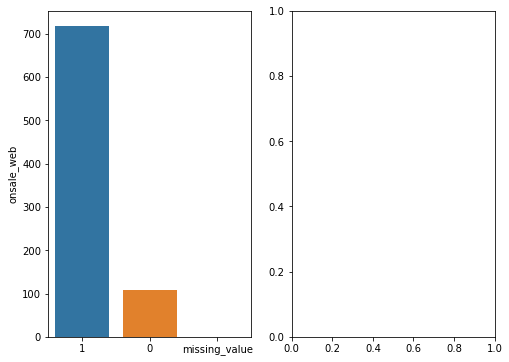

In [79]:
oneD_analysis(erp_cms_df, ['onsale_web'])

In [80]:
# Detection des variables avec une modalité (uniquement dans le cas d'une variable qualitative)

def unique_value_variable(df):
    
    mono_valuated_var = {}
    for var in df.columns:
        is_unique = False
        if len(df[var].reset_index().groupby(by=var).count()) == 1 :
             is_unique = True
        mono_valuated_var[var] = is_unique
    return mono_valuated_var

In [81]:
# Map des valeurs dans un dictionnaire
unique_value_variable(erp_cms_df)

{'product_id': False,
 'id_web': False,
 'onsale_web': False,
 'price': False,
 'stock_quantity': False,
 'stock_status': False,
 'virtual': True,
 'downloadable': True,
 'rating_count': True,
 'average_rating': True,
 'total_sales': False,
 'tax_status': True,
 'post_author': False,
 'post_date': False,
 'post_date_gmt': False,
 'post_title': False,
 'post_excerpt': False,
 'post_status': True,
 'comment_status': True,
 'ping_status': True,
 'post_name': False,
 'post_modified': False,
 'post_modified_gmt': False,
 'post_parent': True,
 'guid': False,
 'menu_order': True,
 'post_type': True,
 'post_mime_type': False,
 'comment_count': True,
 '_merge': False}

In [82]:
# Supprime les variables avec une seule modalité
erp_cms_df.drop(axis = 'columns', columns=[k for (k,v) in unique_value_variable(erp_cms_df).items() if v == True], inplace=True)

## 1.5 Analyse univariée sur une variable quantitative <a name="H15"></a>

In [109]:
# Detection des variables quantitatives
quant_var = [index for index in erp_cms_df.dtypes.index if erp_cms_df.dtypes.loc[index] == 'float64']

In [110]:
# Aucune valeur manquante 
# Aucune valeur aberrante 
# Aucune erreur de saisie
quant_var

['price', 'total_sales', 'post_author']

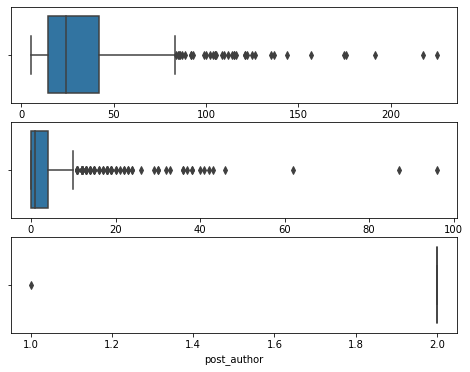

In [112]:
oneD_analysis(erp_cms_df, quant_var, quant = True)

# 2. Analyse du CA sur les ventes <a name="H2"></a>

## 2.1 CA calculé sur les ventes par produit <a name="H21"></a>

In [113]:
web_df_cp = web_df.copy()
erp_df_cp = erp_df.copy()
erp_cms_df_cp = erp_cms_df.copy()

In [114]:
#Total_sales représente la quantité de bouteille de vin vendu pour chaque post_title
erp_cms_df_cp['total_sales']

0      6.0
1      0.0
2      0.0
3      3.0
4      0.0
      ... 
820    0.0
821    0.0
822    0.0
823    NaN
824    0.0
Name: total_sales, Length: 825, dtype: float64

In [115]:
# Les produits dans l'ERP et dont on ne connait pas le nombre de vente (exclus de CMS)
erp_cms_df_cp.replace(np.nan, {'total_sales' : 0}, inplace=True)

In [116]:
erp_cms_df_cp['CA_product'] = erp_cms_df_cp['price'] * erp_cms_df_cp['total_sales']

In [117]:
erp_cms_df_cp[['post_title','CA_product']].sort_values('CA_product', ascending=False).head(15)

,post_title,CA_product
286,Champagne Gosset Grand Blanc de Blancs,4704.0
162,Champagne Gosset Grand Rosé,4263.0
310,Cognac Frapin VIP XO,2288.0
161,Champagne Gosset Grand Millésime 2006,1590.0
160,Champagne Gosset Grande Réserve,1560.0
293,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,1391.5
291,Champagne Egly-Ouriet Grand Cru Millésimé 2008,1125.0
170,Elian Daros Côtes du Marmandais Clos Baquey 2015,1044.0
761,Domaine Giudicelli Patrimonio Blanc 2019,1033.2
121,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,1029.2


## 2.2 CA calculé sur l'ensemble des ventes en ligne <a name="H22"></a>

In [118]:
web_df_cp = web_df.copy()
erp_df_cp = erp_df.copy()
erp_cms_df_cp = erp_cms_df.copy()

**Astuce :** Dans cet exemple, nous pouvons reprendre le dataFrame avec le CA calculé par produit dans la section précédente. 
En effet, nous n'avons pas l'information sur le nombre de vente des bouteilles de vin présentes dans l'ERP.  

**Conclusion :** Aucun filtre n'est necessaire et nous pouvons effectuer la somme sur le CA de tous les produits pour calculer le CA total effectué par les ventes en ligne.


In [119]:
erp_cms_df_cp.replace(np.nan, {'total_sales' : 0}, inplace=True)
erp_cms_df_cp['CA_product'] = (erp_cms_df_cp['price'] * erp_cms_df_cp['total_sales'])

In [120]:
# Le chiffre est d'affaire est calculé par la somme des CA généré par les ventes de chaque produit sur le web
online_CA_ = erp_cms_df_cp['CA_product'].sum()

In [121]:
online_CA_

70568.6

# 3. Analyse des outliers sur le prix des produits <a name="H3"></a>

## 3.1 Représentation des valeurs aberrantes par un boxplot <a name="H31"></a>

In [122]:
import seaborn as sns

In [123]:
erp_cms_df_cp = erp_cms_df.copy() 

In [124]:
erp_cms_df_cp['price'].describe()

count    825.000000
mean      32.415636
std       26.795849
min        5.200000
25%       14.600000
50%       24.400000
75%       42.000000
max      225.000000
Name: price, dtype: float64

In [125]:
# 1ere aberrationA t-on des prix négatif ? 

(erp_cms_df_cp['price'] < 0).all()

# Aucun prix inférieur à 0

False

<AxesSubplot:xlabel='price'>

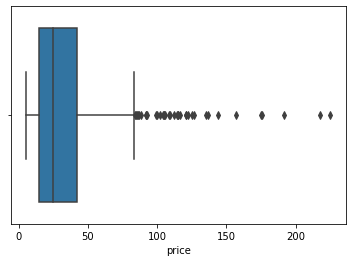

In [126]:
sns.boxplot(x=erp_cms_df_cp['price'])

## 3.2 IQR pour calculer les limites de notre distribution <a name="H32"></a>

In [127]:
# fonction qui calcule les bornes limites 
def IQR_calculation(df, column):
    
    Q1 = np.percentile(df.loc[:, column], 25, interpolation='midpoint')
    Q3 = np.percentile(df.loc[:, column], 75, interpolation='midpoint')

    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    outlier_cond = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    return outlier_cond

In [128]:
outlier_interval = IQR_calculation(erp_cms_df_cp,'price')

In [129]:
erp_cms_df_cp.loc[outlier_interval,'price']

19      86.1
30     144.0
47      84.7
55      92.0
154    100.0
156     88.4
291    225.0
293    126.5
297     85.6
310    176.0
311    108.5
313    157.0
314    104.0
320    109.6
477    102.3
478    137.0
525    217.5
530    105.0
531    105.0
538    112.0
539     86.8
605     92.0
610     83.7
615    124.8
657    175.0
692    191.3
707     93.0
708    122.0
709    114.0
752    135.0
757    105.6
758    116.4
763    115.0
764    121.0
765     99.0
766    115.0
767    121.0
Name: price, dtype: float64

In [137]:
erp_cms_df_cp.loc[outlier_interval, 'price'].count()

37

## 3.3 La méthode du Z score <a name="H33"></a>

<AxesSubplot:xlabel='price', ylabel='Count'>

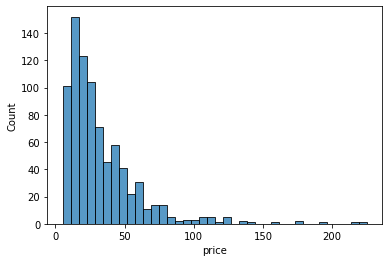

In [130]:
# Supposons que notre variable aléatoire qui décrit notre population suit une loi normale  
sns.histplot(x=erp_cms_df_cp['price'])

In [131]:
from scipy import stats

Le threshold que l'on note Z permet de délimiter notre distribution en calculant des bornes inférieures et supérieur.  
Les valeurs remarquables avec Z sont : (Z une variable aléatoire qui suit une loi Normale(0,1)) :
* P(Z > 3) = 0,0025
* P(Z > 2) = 0,05
* P(Z > 1) = 0,32

In [132]:
erp_cms_df_cp['z_score'] = stats.zscore(erp_cms_df_cp['price'])
threshold = 3

In [133]:
# zscore_df contient toutes les outliers de la variable prix
# Nan veut dire "en magasin"
zscore_df = erp_cms_df_cp.loc[erp_cms_df_cp['z_score'] > threshold, ['post_title','price']].sort_values('price', ascending=False).head(10)

In [134]:
zscore_df['google_price'] = [900, 215, 215, 180, 155,145, 1,168, 150, 180]

In [135]:
zscore_df['market_balance (%)'] = (zscore_df['price'] - zscore_df['google_price'])*100 / zscore_df['google_price']

In [136]:
zscore_df

,post_title,price,google_price,market_balance (%)
291,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,900,-75.000000
525,David Duband Charmes-Chambertin Grand Cru 2014,217.5,215,1.162791
692,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,215,-11.023256
310,Cognac Frapin VIP XO,176.0,180,-2.222222
657,Camille Giroud Clos de Vougeot 2016,175.0,155,12.903226
313,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,145,8.275862
30,NaN,144.0,1,14300.000000
478,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0,168,-18.452381
752,Champagne Gosset Célébris Vintage 2007,135.0,150,-10.000000
293,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,180,-29.722222
